# Noise mix

See 2023_noise for scripts.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [ ]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [ ]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [ ]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [ ]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [ ]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [ ]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

In [ ]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

In [ ]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

In [ ]:
# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'GM12878', 'rep1')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

In [ ]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Compute BAM coverage

In [ ]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            # # Limit cells
            # if cell not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
            #     continue
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [ ]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams

In [ ]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams

In [ ]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)
df_bams = df_bams.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_bams[['modification', 'cell', 'replicate']].iterrows()]].copy()

In [ ]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        hue_order=MODIFICATIONS+['Control']
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Find control tracks

In [ ]:
! mkdir -p {DOWNSAMPLE_DIR}/bams
controls = []
control_reads = []

for _, (ds, m, c, r) in tqdm(
        df_bams[['dataset', 'modification', 'cell', 'replicate']].iterrows()):
    if m == 'Control':
        controls.append(None)
        control_reads.append(None)
        continue
    # # Limit cells
    # if c not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
    #     controls.append(None)
    #     control_reads.append(None)
    #     continue
    print(ds, m, c, r)
    t = df_bams[(df_bams['dataset'] == ds) & (df_bams['modification'] == 'Control') & (df_bams['cell'] == c)]
    tr = t[t['replicate'] == r]
    bam, reads = None, None
    if len(tr) == 1:
        bam = tr['bam_file'].values[0]
        reads = tr['reads'].values[0]
    elif len(t) == 1:
        bam = t['bam_file'].values[0]
        reads = t['reads'].values[0]
    controls.append(bam)
    control_reads.append(reads)
    if bam is None:
        print('No control', ds, m, c, r)
        continue

df_bams['control_file'] = controls
df_bams['control_reads'] = control_reads
df_bams.sample(3)

# Mix control
Use chromosome 1 for speed purposes.

In [ ]:
MIX_DIR = os.path.expanduser('~/data/2023_mix_chr1')
# MIX_DIR = os.path.expanduser('~/data/2023_mix')
MIX_SIGNAL_FRACTIONS = [0.7, 0.5, 0.2, 0.1]

In [ ]:
# ! mkdir -p {MIX_DIR}/bams
# 
# tf = tempfile.mktemp()
# 
# mixtures = []
# for _, (ds, m, c, r, bam_file, control_file, reads, control_reads) in tqdm(
#         df_bams[df_bams['modification'] != 'Control'][
#             ['dataset', 'modification', 'cell', 'replicate', 'bam_file', 'control_file', 'reads', 'control_reads']
#         ].iterrows()):
#     # Limit cells
#     if c not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
#         continue    
#     print(ds, m, c, r)
#     control_name = os.path.basename(control_file)
#     ! ln -sf {control_file} {MIX_DIR}/bams/{control_name}
#     
#     for fraction in MIX_SIGNAL_FRACTIONS:
#         print(fraction)
#         result_file = f'{MIX_DIR}/bams/{m}_{c}_{r}_{fraction}.bam'
#         print(result_file)
#         mixtures.append((ds, m, c, r, fraction, result_file))
#         if os.path.exists(result_file):
#             continue
#         control_fraction = min(1.0, (1.0 - fraction) * reads / control_reads)
#         ! samtools view -@ 4 -H {bam_file} > {tf}.sam
#         ! samtools view -@ 4 -s {fraction} {bam_file} >> {tf}.sam
#         ! samtools view -@ 4 -s {control_fraction} {control_file} >> {tf}.sam
#         ! samtools view -S -b {tf}.sam > {tf}.bam
#         ! samtools sort {tf}.bam -o {result_file}
#         ! rm {tf}.sam {tf}.bam
#     
# df_mixtures = pd.DataFrame(mixtures, columns=['dataset', 'modification', 'cell', 'replicate', 'fraction', 'bam_file'])
# del mixtures
# df_mixtures.sample(3)        

In [ ]:
! mkdir -p {MIX_DIR}/bams

tf = tempfile.mktemp()
tab = '\t'

mixtures = []
for _, (ds, m, c, r, bam_file, control_file, reads, control_reads) in tqdm(list(
        df_bams[df_bams['modification'] != 'Control'][
            ['dataset', 'modification', 'cell', 'replicate', 'bam_file', 'control_file', 'reads', 'control_reads']
        ].iterrows())):
    # # Limit cells
    # if c not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
    #     continue
    print(ds, m, c, r)
    control_name = os.path.basename(control_file)
    if not os.path.exists(f'{MIX_DIR}/bams/{control_name}'):
        print('Control')
        ! samtools view -@ 4 -H {control_file} > {tf}.sam
        ! samtools view -@ 4 {control_file} | grep "chr1{tab}" >> {tf}.sam
        ! samtools view -S -b {tf}.sam > {tf}.bam
        ! samtools sort {tf}.bam -o {MIX_DIR}/bams/{control_name}
        ! rm {tf}.sam {tf}.bam
        # ! ln -sf {control_file} {MIX_DIR}/bams/{control_name}

    for fraction in MIX_SIGNAL_FRACTIONS:
        print(fraction)
        result_file = f'{MIX_DIR}/bams/{m}_{c}_{r}_{fraction}.bam'
        print(result_file)
        mixtures.append((ds, m, c, r, fraction, result_file))
        if os.path.exists(result_file):
            continue
        control_fraction = min(1.0, (1.0 - fraction) * reads / control_reads)
        ! samtools view -@ 4 -H {bam_file} > {tf}.sam
        ! samtools view -@ 4 -s {fraction} {bam_file} | grep "chr1{tab}" >> {tf}.sam
        ! samtools view -@ 4 -s {control_fraction} {control_file} | grep "chr1{tab}" >> {tf}.sam
        ! samtools view -S -b {tf}.sam > {tf}.bam
        ! samtools sort {tf}.bam -o {result_file}
        ! rm {tf}.sam {tf}.bam

df_mixtures = pd.DataFrame(mixtures, columns=['dataset', 'modification', 'cell', 'replicate', 'fraction', 'bam_file'])
del mixtures
df_mixtures.sample(3)

## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False span=True sicer=True --rerun-trigger mtime; 
```

# Analyze results

In [517]:
! mkdir -p {MIX_DIR}/original_chr1

mixed_peaks_df = load_peaks_path(MIX_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS, GSE26320_REPS + IMMUNE_REPS)
mixed_peaks_df['dataset'] = 'ENCODE'
mixed_peaks_df.loc[mixed_peaks_df['cell'].isin(IMMUNE_CELLS), 'dataset'] = 'Roadmap'
mixed_peaks_df['fraction'] = 0
for fraction in MIX_SIGNAL_FRACTIONS:
    mixed_peaks_df.loc[(mixed_peaks_df['file'].str.contains(f'_{fraction}_')) |
                       (mixed_peaks_df['file'].str.contains(f'_{fraction}-')), 'fraction'] = fraction
t = df_peaks[(df_peaks['cell'].isin(mixed_peaks_df['cell'].unique())) &
             (df_peaks['replicate'].isin(mixed_peaks_df['replicate'].unique()))][[
    'file', 'modification', 'cell', 'replicate', 'peaks', 'tool', 'dataset']].copy()
t['fraction'] = 1.0
# Processing original files
t = df_peaks[(df_peaks['cell'].isin(mixed_peaks_df['cell'].unique())) &
             (df_peaks['replicate'].isin(mixed_peaks_df['replicate'].unique()))][[
    'file', 'modification', 'cell', 'replicate', 'peaks', 'tool', 'dataset']].copy()
t['fraction'] = 1.0
chr1_files = []
chr1_peaks = []
for file in tqdm(t['file']):
    chr1_file = f'{MIX_DIR}/original_chr1/{os.path.basename(file)}'
    if not os.path.exists(chr1_file):
        tab = '\t'
        ! cat {file} | grep "chr1{tab}" > {chr1_file}
    chr1_files.append(chr1_file)
    chr1_peaks.append(lines(chr1_file))
t['file'] = chr1_files
t['peaks'] = chr1_peaks
mixed_peaks_df = pd.concat([mixed_peaks_df, t]).reset_index(drop=True)
mixed_peaks_df.sample(3)

  0%|          | 0/4000 [00:00<?, ?it/s]

MACS2 500


  0%|          | 0/4000 [00:00<?, ?it/s]

MACS2 broad 500


  0%|          | 0/500 [00:00<?, ?it/s]

SICER 500


  0%|          | 0/503 [00:00<?, ?it/s]

SPAN 500


  0%|          | 0/504 [00:00<?, ?it/s]

,file,modification,cell,replicate,peaks,tool,dataset,fraction
734,/home/jetbrains/data/2023_mix_chr1/macs2/H3K27...,H3K27ac,K562,rep1,558,MACS2 broad,ENCODE,0.1
2404,/home/jetbrains/data/2023_mix_chr1/original_ch...,H3K4me1,Monocyte,,11022,MACS2 broad,Roadmap,1.0
1896,/home/jetbrains/data/2023_mix_chr1/span/H3K27m...,H3K27me3,HSMM,rep2,1801,SPAN,ENCODE,0.5


## Peaks number

In [518]:
def plot_modified(df, y, line):
    for ds in ['ENCODE', 'Roadmap']:
        print(ds)
        plt.figure(figsize=(15, 3))
        axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

        for i, m in enumerate(MODIFICATIONS):
            ax = axs[i]
            t = df[(df['dataset'] == ds) & (df['modification'] == m)].copy()
            fractions = sorted(df['fraction'].unique(), reverse=True)
            t['j'] = 0
            for j, fraction in enumerate(fractions):
                t.loc[t['fraction'] == fraction, 'j'] = j
            if line:
                sns.lineplot(data=t,
                             x='j', y=y, hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=10
                             )
                ax.set_xticks(range(len(fractions)), minor=False)
                ax.set_xticklabels([str(f) for f in fractions])
                ax.set_xlabel('fraction')
                # We could use just invert axis, but this won't make linear dots
                # ax.invert_xaxis()
            else:
                sns.barplot(data=t,
                                    x='tool', y=y, hue='fraction', ax=ax,
                                    capsize=.1, errwidth=2, edgecolor="black",
                                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                    hue_order = sorted(df['fraction'].unique(), reverse=True),
                                    )
            # ax.set_ylim(0, 110_000)
            ax.xaxis.set_tick_params(rotation=90)
            ax.title.set_text(m)
            if i > 0:
                ax.set_ylabel(None)
            if i < len(axs) - 1:
                ax.legend().set_visible(False)
            else:
                # Put a legend to the right of the current axis
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    

        plt.tight_layout()
        plt.show()

Mixed
ENCODE


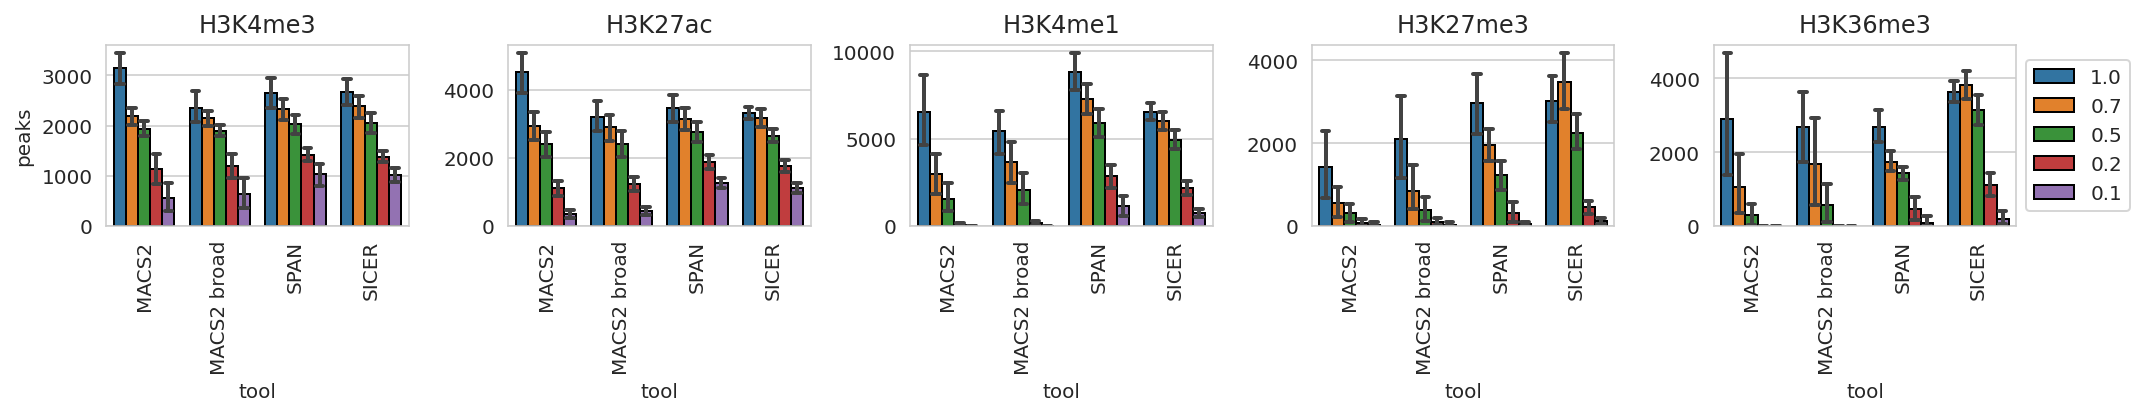

Roadmap


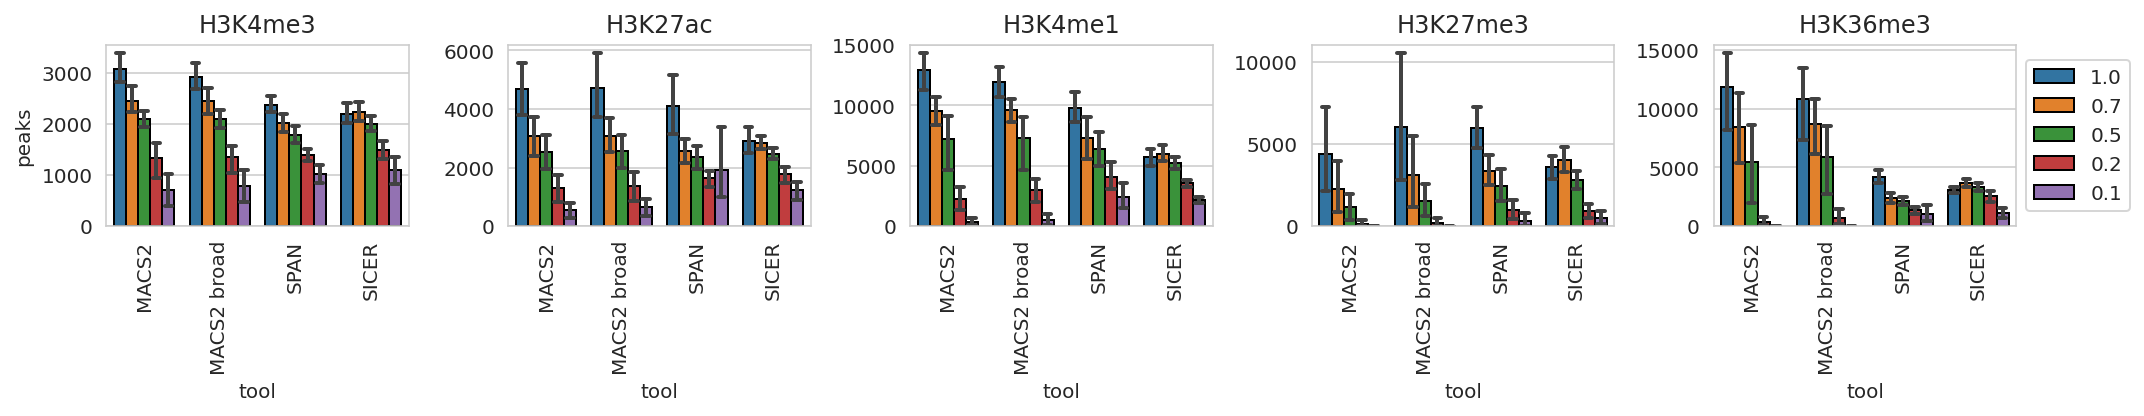

In [519]:
print('Mixed')
plot_modified(mixed_peaks_df, 'peaks', False)

## Jaccard vs original peaks

In [520]:
def overlap_vs_original(df):
    tf = tempfile.mktemp()
    overlaps = []
    for _, (ds, m, c, r, fraction, tool, file) in tqdm(df[df['fraction'] != 1.0][[
        'dataset', 'modification', 'cell', 'replicate', 'fraction', 'tool', 'file'
    ]].iterrows()):
        t = df[(df['fraction'] == 1.0) &
                           (df['dataset'] == ds) &
                           (df['modification'] == m) &
                           (df['cell'] == c) &
                           (df['replicate'] == r) &
                           (df['tool'] == tool)]
        if len(t) == 0:
            print('No original peaks for', ds, m, c, r, tool)
            continue
        original_file = t['file'].values[0]
        original_peaks = lines(original_file)
        original_peaks_len = int(bedl(original_file).sum())
        peaks = lines(file)
        peaks_len = int(bedl(file).sum())
        !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
        original_peaks_overlap = lines(tf)
        !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -a {original_file} -b {file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        overlaps.append((ds, m, c, r, fraction, tool, 
                         peaks, peaks_len, original_peaks, original_peaks_len,
                         peaks_overlap, original_peaks_overlap, overlap_len, 
                         d(overlap_len, peaks_len + original_peaks_len - overlap_len)))
        
    return pd.DataFrame(overlaps, columns=[
        'dataset', 'modification', 'cell', 'replicate', 'fraction', 'tool', 
        'peaks', 'peaks_len', 'original_peaks', 'original_peaks_len',
        'peaks_overlap', 'original_peaks_overlap', 'overlap_len', 'jaccard'
    ])

In [521]:
mixed_peaks_overlap_df = overlap_vs_original(mixed_peaks_df)
# Add 1.0 and 0.0 fraction
for _, (ds, m, c, r, t) in list(
        mixed_peaks_overlap_df[
            ['dataset', 'modification', 'cell', 'replicate', 'tool']].drop_duplicates().iterrows()):
    mixed_peaks_overlap_df.loc[len(mixed_peaks_overlap_df)] = \
        [ds, m, c, r, 0.0, t] + [None] * (len(mixed_peaks_overlap_df.columns) - 7) + [0.0]
    mixed_peaks_overlap_df.loc[len(mixed_peaks_overlap_df)] = \
        [ds, m, c, r, 1.0, t] + [None] * (len(mixed_peaks_overlap_df.columns) - 7) + [1.0]
mixed_peaks_overlap_df.sample(3)

0it [00:00, ?it/s]

,dataset,modification,cell,replicate,fraction,tool,peaks,peaks_len,original_peaks,original_peaks_len,peaks_overlap,original_peaks_overlap,overlap_len,jaccard
1613,Roadmap,H3K27me3,CD4,rep2,0.1,SPAN,14,2368,6395,2618244,4,4,633,0.000242
177,ENCODE,H3K27ac,GM12878,rep1,0.1,MACS2,189,85847,4423,3997446,189,144,85803,0.021464
2868,ENCODE,H3K27me3,HepG2,rep1,0.0,SPAN,None,None,None,None,None,None,None,0.000000


In [522]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
rfile = f'{MIX_DIR}/mixed_peaks_overlap_df_{now}.csv.gz'
print(rfile)
mixed_peaks_overlap_df.to_csv(rfile, compression='gzip', index=None)

/home/jetbrains/data/2023_mix_chr1/mixed_peaks_overlap_df_2023-12-11T00:16.csv.gz


In [523]:
# mixed_peaks_overlap_df = pd.read_csv('~/data/2023_mix/mixed_peaks_overlap_df_2023-11-22T23:50.csv.gz', compression='gzip')
# mixed_peaks_overlap_df.sample(3)

In [524]:
# print('Mixed control')
# plot_modified(mixed_peaks_overlap_df[mixed_peaks_overlap_df['cell'].isin(
#     ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte'])], 'jaccard', True)

Mixed control
ENCODE


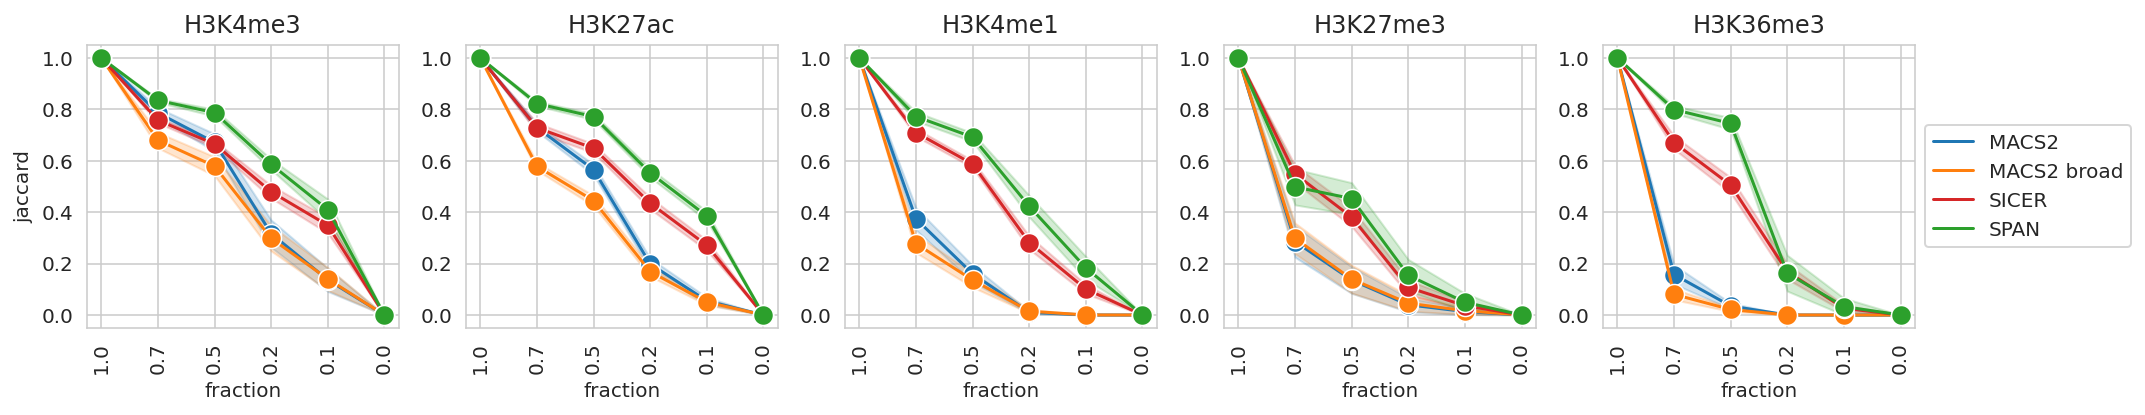

Roadmap


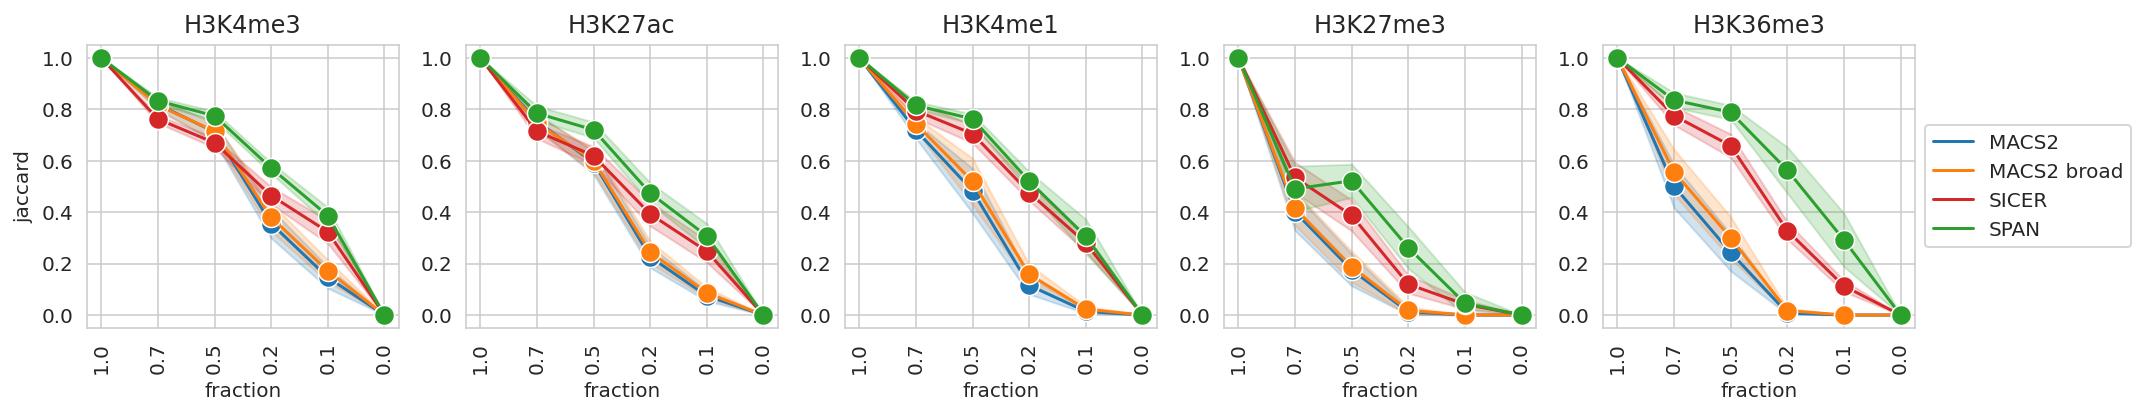

In [525]:
print('Mixed control')
plot_modified(mixed_peaks_overlap_df, 'jaccard', True)

ENCODE


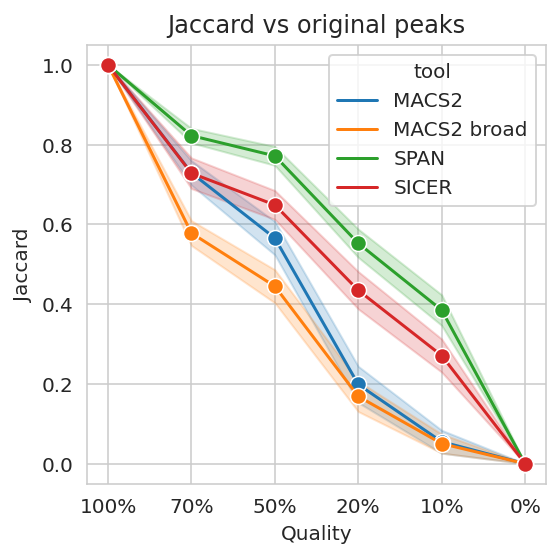

In [526]:
print('ENCODE')
plt.figure(figsize=(4, 4))
t = mixed_peaks_overlap_df[
    (mixed_peaks_overlap_df['dataset']=='ENCODE') &
    (mixed_peaks_overlap_df['modification']=='H3K27ac')
    ].copy()
t.sort_values(by=['fraction'], ascending=False, inplace=True)
t['quality'] = [f'{int(f * 100)}%' for f in t['fraction']]
sns.lineplot(data=t, x="quality", y="jaccard", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar=('sd', .5), marker='o', markersize=8)
plt.title('Jaccard vs original peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [527]:
def compute_auc(df, x):
    rows = []
    for (ds, m, c, r, tool), t in df.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
        t = t.copy()
        t.sort_values(by=['fraction'], inplace=True)
        auc = 0
        fraction_prev = 0
        value_prev = 0
        for _, (fraction, value) in t[['fraction', x]].iterrows():
            auc += (fraction - fraction_prev) * (value + value_prev) / 2
            fraction_prev, value_prev = fraction, value
        rows.append((ds, m, c, r, tool, auc))
    return pd.DataFrame(data=rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'auc'])

In [528]:
mixed_peaks_overlap_auc_df = compute_auc(mixed_peaks_overlap_df, 'jaccard')
mixed_peaks_overlap_auc_df.sample(3)

,dataset,modification,cell,replicate,tool,auc
34,ENCODE,H3K27ac,HepG2,rep2,SICER,0.678112
440,Roadmap,H3K4me1,CD4,,MACS2,0.449972
53,ENCODE,H3K27ac,NHEK,rep1,MACS2 broad,0.471522


ENCODE


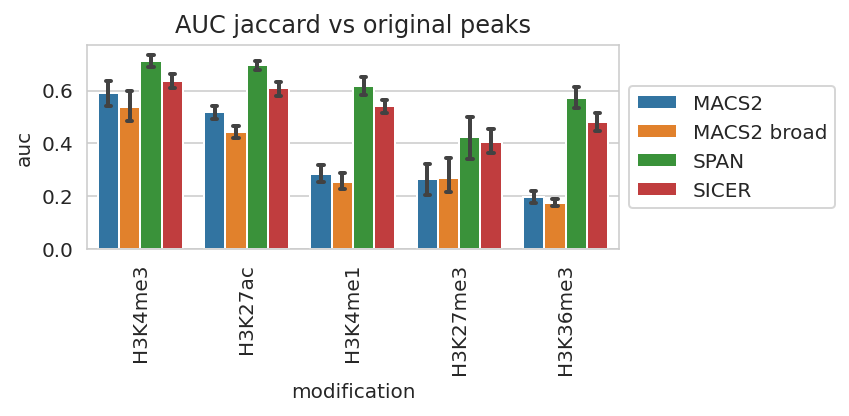

Roadmap


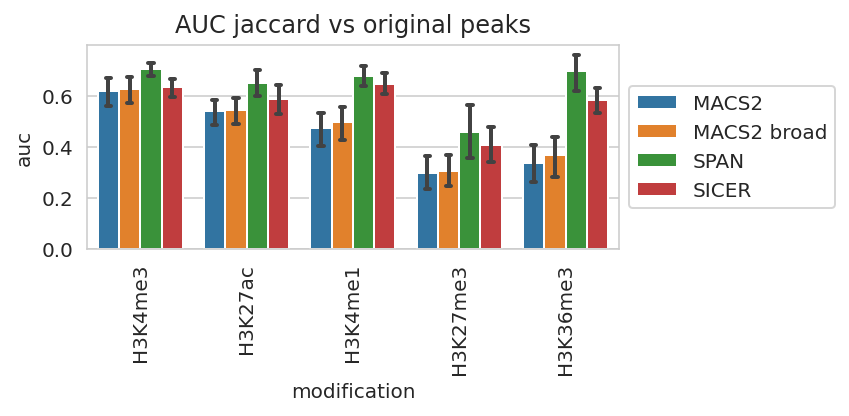

In [529]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 3))
    ax = plt.axes()
    ax.title.set_text('AUC jaccard vs original peaks')
    g_results = sns.barplot(data=mixed_peaks_overlap_auc_df[mixed_peaks_overlap_auc_df['dataset']==ds], 
                            x='modification', y='auc',
                            hue='tool',
                            ax=ax,
                            capsize=.05, errwidth=2,
                            order=MODIFICATIONS,
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            )
    ax.xaxis.set_tick_params(rotation=90)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard between replicates

In [530]:
def compute_reps_overlap(df_peaks, modifications, cells):
    reps_overlap = pd.DataFrame(columns=['dataset', 'modification', 'cell', 'fraction', 'tool', 'rep1', 'rep2',
                                         'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                         'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tf = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for ds, m, c, f in tqdm(list(product(['ENCODE', 'Roadmap'], modifications, cells, MIX_SIGNAL_FRACTIONS + [1.0]))):
        print(ds, m, c, f)
        tm = df_peaks[(df_peaks['dataset'] == ds) & (df_peaks['modification'] == m) & (df_peaks['cell'] == c) & (df_peaks['fraction'] == f)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    file1 = sorted_file(t1['file'].values[0])
                    file2 = sorted_file(t2['file'].values[0])
                    peaks1 = t1['peaks'].values[0]
                    peaks1_len = int(bedl(file1).sum())
                    peaks2 = t2['peaks'].values[0]
                    peaks2_len = int(bedl(file2).sum())
                    !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                    overlap1 = lines(tf)
                    !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                    overlap2 = lines(tf)
                    !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                    overlap_len = int(last_col(tf).sum())

                    reps_overlap.loc[len(reps_overlap)] = \
                        (ds, m, c, f, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                         overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]
    return reps_overlap    

In [531]:
df_reps_overlap = compute_reps_overlap(mixed_peaks_df, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS)
# Add 0.0 fraction
for _, (ds, m, c, t) in list(
        df_reps_overlap[
            ['dataset', 'modification', 'cell', 'tool']].drop_duplicates().iterrows()):
    df_reps_overlap.loc[len(df_reps_overlap)] = \
        [ds, m, c, 0.0, t] + [None] * (len(df_reps_overlap.columns) - 6) + [0.0]
df_reps_overlap.sample(5)

  0%|          | 0/900 [00:00<?, ?it/s]

ENCODE H3K4me3 GM12878 0.7
ENCODE H3K4me3 GM12878 0.5
ENCODE H3K4me3 GM12878 0.2
ENCODE H3K4me3 GM12878 0.1
ENCODE H3K4me3 GM12878 1.0
ENCODE H3K4me3 HMEC 0.7
ENCODE H3K4me3 HMEC 0.5
ENCODE H3K4me3 HMEC 0.2
ENCODE H3K4me3 HMEC 0.1
ENCODE H3K4me3 HMEC 1.0
ENCODE H3K4me3 HSMM 0.7
ENCODE H3K4me3 HSMM 0.5
ENCODE H3K4me3 HSMM 0.2
ENCODE H3K4me3 HSMM 0.1
ENCODE H3K4me3 HSMM 1.0
ENCODE H3K4me3 K562 0.7
ENCODE H3K4me3 K562 0.5
ENCODE H3K4me3 K562 0.2
ENCODE H3K4me3 K562 0.1
ENCODE H3K4me3 K562 1.0
ENCODE H3K4me3 NHEK 0.7
ENCODE H3K4me3 NHEK 0.5
ENCODE H3K4me3 NHEK 0.2
ENCODE H3K4me3 NHEK 0.1
ENCODE H3K4me3 NHEK 1.0
ENCODE H3K4me3 NHLF 0.7
ENCODE H3K4me3 NHLF 0.5
ENCODE H3K4me3 NHLF 0.2
ENCODE H3K4me3 NHLF 0.1
ENCODE H3K4me3 NHLF 1.0
ENCODE H3K4me3 H1 0.7
ENCODE H3K4me3 H1 0.5
ENCODE H3K4me3 H1 0.2
ENCODE H3K4me3 H1 0.1
ENCODE H3K4me3 H1 1.0
ENCODE H3K4me3 Huvec 0.7
ENCODE H3K4me3 Huvec 0.5
ENCODE H3K4me3 Huvec 0.2
ENCODE H3K4me3 Huvec 0.1
ENCODE H3K4me3 Huvec 1.0
ENCODE H3K4me3 HepG2 0.7
ENCOD

,dataset,modification,cell,fraction,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks2_overlap,peaks_overlap_len,jaccard
479,ENCODE,H3K27me3,HMEC,1.0,SPAN,rep1,rep2,3829,52824665,1048,2054874,563,1016,2009518,0.038009
546,ENCODE,H3K27me3,H1,0.5,SICER,rep1,rep2,1064,3542336,1377,6326423,845,747,2991721,0.435030
302,ENCODE,H3K4me1,GM12878,0.7,SICER,rep1,rep2,6149,16759451,4525,16482075,4166,3981,11850995,0.554030
978,ENCODE,H3K4me3,K562,0.0,SICER,None,None,None,None,None,None,None,None,None,0.000000
137,ENCODE,H3K4me3,Huvec,1.0,MACS2 broad,rep1,rep2,2396,3848814,1590,2495956,1417,1485,2279826,0.560851


In [532]:
mixed_peaks_df[(mixed_peaks_df['dataset'] == 'Roadmap') & (mixed_peaks_df['modification'] == 'H3K27ac')][['cell', 'replicate']].drop_duplicates()

,cell,replicate
3,BCell,
32,Monocyte,
61,CD4,
81,CD4,rep1
90,NK,
124,PBMC,
139,TCell,
395,CD34,rep2
2353,CD34,


Mixed control replicates overlap
ENCODE


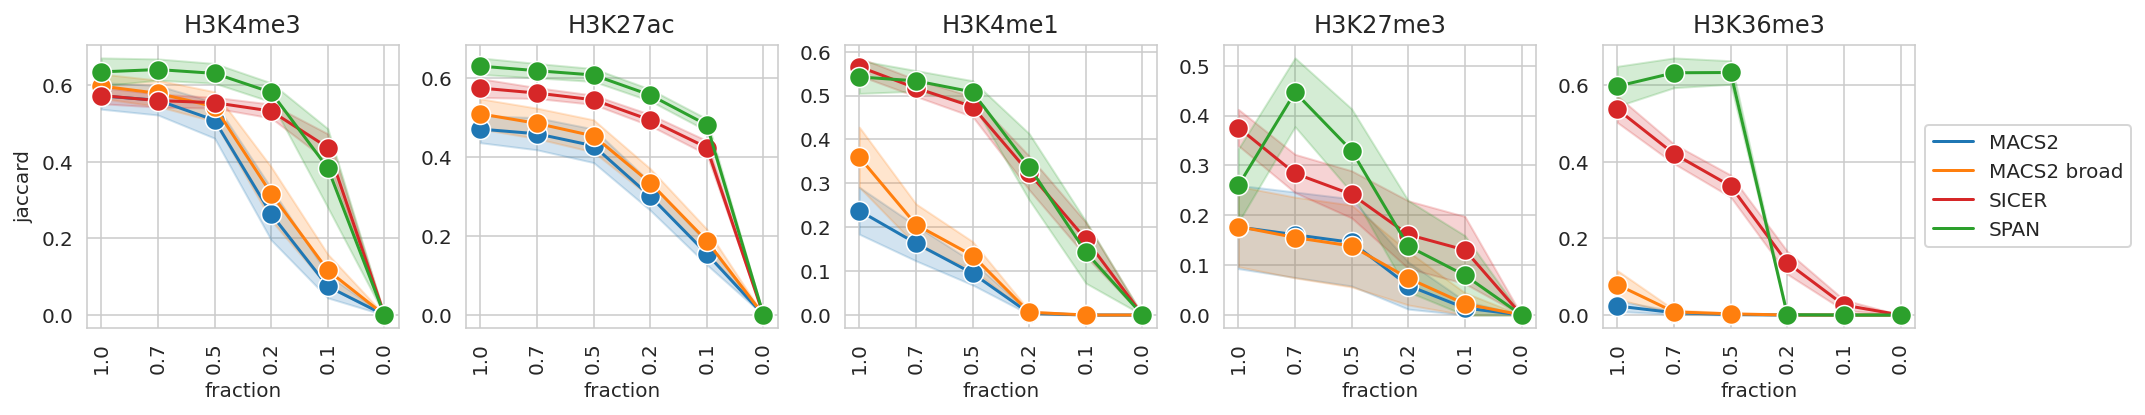

Roadmap


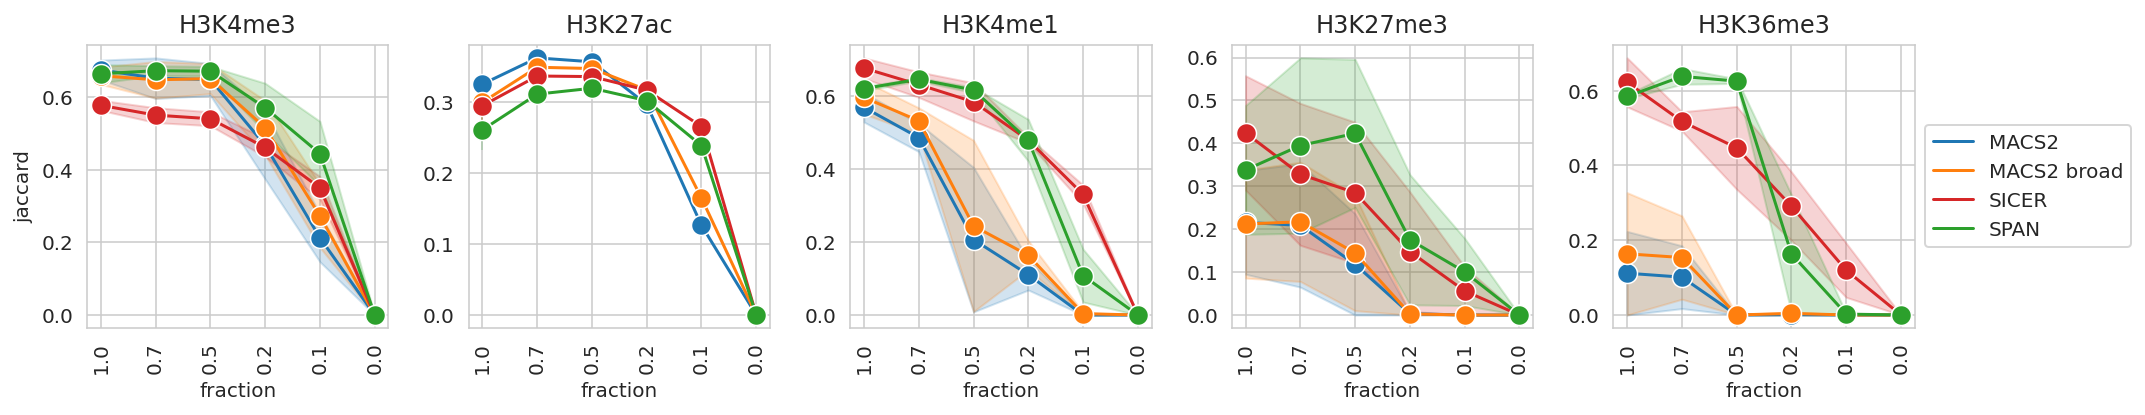

In [533]:
print('Mixed control replicates overlap')
plot_modified(df_reps_overlap, 'jaccard', True)

ENCODE


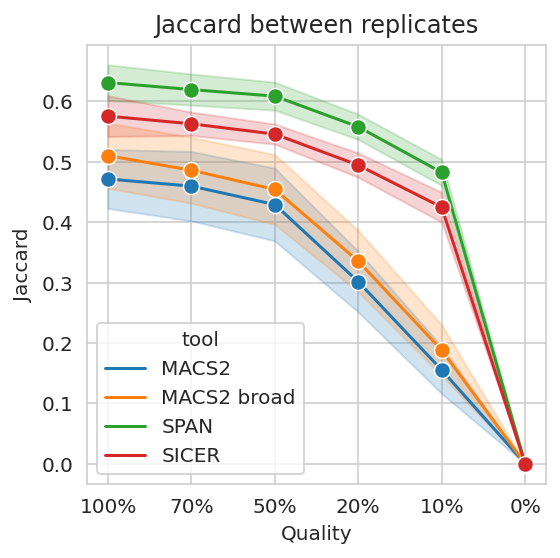

In [534]:
print('ENCODE')
plt.figure(figsize=(4, 4))
t = df_reps_overlap[
    (df_reps_overlap['dataset']=='ENCODE') &
    (df_reps_overlap['modification']=='H3K27ac') 
    ].copy()
t.sort_values(by=['fraction'], ascending=False, inplace=True)
t['quality'] = [f'{int(f * 100)}%' for f in t['fraction']]
sns.lineplot(data=t, x="quality", y="jaccard", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar=('sd', .5), marker='o', markersize=8)
plt.title('Jaccard between replicates')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [535]:
def compute_auc_reps(df, x):
    rows = []
    for (ds, m, c, tool), t in df.groupby(['dataset', 'modification', 'cell', 'tool']):
        t = t.copy()
        t.sort_values(by=['fraction'], inplace=True)
        auc = 0
        fraction_prev = 0
        value_prev = 0
        for _, (fraction, value) in t[['fraction', x]].iterrows():
            auc += (fraction - fraction_prev) * (value + value_prev) / 2
            fraction_prev, value_prev = fraction, value
        rows.append((ds, m, c, tool, auc))
    return pd.DataFrame(data=rows, columns=['dataset', 'modification', 'cell', 'tool', 'auc'])

In [536]:
df_reps_overlap_auc_df = compute_auc_reps(df_reps_overlap, 'jaccard')
df_reps_overlap_auc_df.sample(3)

,dataset,modification,cell,tool,auc
69,ENCODE,H3K36me3,HMEC,MACS2 broad,0.000000
72,ENCODE,H3K36me3,HSMM,MACS2,0.001547
89,ENCODE,H3K36me3,NHLF,MACS2 broad,0.000000


ENCODE


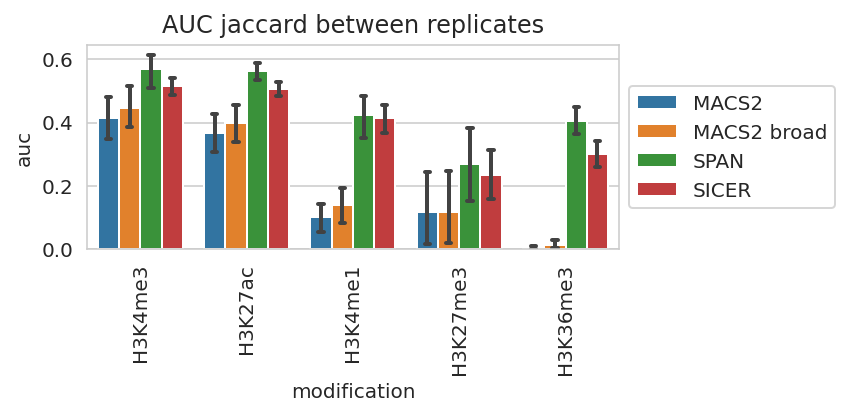

Roadmap


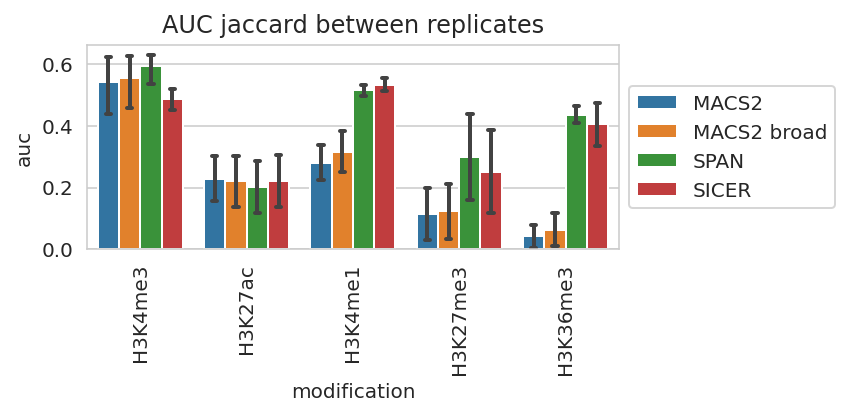

In [537]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 3))
    ax = plt.axes()
    ax.title.set_text('AUC jaccard between replicates')
    g_results = sns.barplot(data=df_reps_overlap_auc_df[df_reps_overlap_auc_df['dataset']==ds],
                            x='modification', y='auc',
                            hue='tool',
                            ax=ax,
                            capsize=.05, errwidth=2,
                            order=MODIFICATIONS,
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            )
    ax.xaxis.set_tick_params(rotation=90)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()